In [1]:
import json
import random

file = open('../data/Ferrara2023-citizens-individualChallenges.json')
file = [json.loads(line) for line in file]
filtered_data = [{
    'user': data['playerId'],
    'start': data['concept']['start'],
    'end': data['concept']['end'],
    'counter': data['concept']['fields']['counterName'],
    'target': data['concept']['fields']['target'],
    'periodTarget': data['concept']['fields']['periodTarget'],
    'completed': data['concept']['completed'],
} for data in file]

random.choice(file)

{'_id': 'ZQlVW1PeKEMmQg9o',
 'name': 'w23_rs__green leaves_44be3eb9-36ff-4656-aa0b-fd857a460345',
 'playerId': 'u_c2eb26caa1e34d82a6f0f2d8778531fe',
 'gameId': '6437ddadf8e59353e50d143e',
 'concept': {'modelName': 'repetitiveBehaviour',
  'fields': {'bonusScore': 100.0,
   'typePoi': None,
   'weblink': None,
   'bonusPointType': 'green leaves',
   'periodName': 'daily',
   'category': None,
   'target': 45.0,
   'surveyType': None,
   'link': None,
   'wi': None,
   'counterName': 'green leaves',
   'periodTarget': 2.0,
   'percentage': None,
   'baseline': None},
  'start': '2023-09-24 22:00:00.000',
  'end': '2023-10-01 21:59:00.000',
  'completed': False,
  'state': 'ASSIGNED',
  'stateDate': {'ASSIGNED': '2023-09-19 08:01:31.268',
   'FAILED': None,
   'ACTIVE': None,
   'COMPLETED': None,
   'PROPOSED': None},
  'group': False,
  'priority': 0,
  'forced': False,
  'visibility': {'hidden': True, 'disclosureDate': '2023-09-20 10:01:31.269'},
  'clock': {'_class': 'eu.trentorise.ga

In [2]:
import pandas as pd

df = pd.DataFrame(filtered_data)
df.dropna(subset=['counter'], inplace=True)
df['target'] = df['target'].astype(int)
df['challenge'] = df['counter'] + ' ' + df['target'].astype(str) + ' ' + df['periodTarget'].astype(str)

df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

df.sort_values(by=['start'], inplace=True)
df

,user,start,end,counter,target,periodTarget,completed,challenge
50,u_0bea6988-bd00-4aa6-a456-4285744356ee,2023-04-23 22:00:00,2023-04-30 22:00:00,Walk_Km,1,NaN,True,Walk_Km 1 nan
65,u_f4b95ec9-5f53-48d8-8adf-fa61be00c967,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0
63,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0
62,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,2023-04-23 22:00:00,2023-04-30 22:00:00,Walk_Km,1,NaN,True,Walk_Km 1 nan
61,u_e4a7a7fcd26644e9961e3e05bf98454e,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0
...,...,...,...,...,...,...,...,...
6902,u_553c90102f4e48f88e4617393a5550a1,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0
6901,u_553c90102f4e48f88e4617393a5550a1,2023-09-24 22:00:00,2023-10-01 21:59:00,Walk_Km,1,NaN,False,Walk_Km 1 nan
6900,u_54061e0911df4785a154a10fdf6def06,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0
6898,u_53b60c2f-f860-47ef-a905-7ee29bea6494,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0


In [3]:
import holidays
it_holidays = holidays.IT(years=2023, subdiv='FE')

df['holiday'] = df.apply(lambda x: any([h in it_holidays for h in pd.date_range(x['start'], x['end'])]), axis=1).astype(int)
df['month'] = df['start'].dt.month

df

,user,start,end,counter,target,periodTarget,completed,challenge,holiday,month
50,u_0bea6988-bd00-4aa6-a456-4285744356ee,2023-04-23 22:00:00,2023-04-30 22:00:00,Walk_Km,1,NaN,True,Walk_Km 1 nan,1,4
65,u_f4b95ec9-5f53-48d8-8adf-fa61be00c967,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0,1,4
63,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0,1,4
62,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,2023-04-23 22:00:00,2023-04-30 22:00:00,Walk_Km,1,NaN,True,Walk_Km 1 nan,1,4
61,u_e4a7a7fcd26644e9961e3e05bf98454e,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0,1,4
...,...,...,...,...,...,...,...,...,...,...
6902,u_553c90102f4e48f88e4617393a5550a1,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0,0,9
6901,u_553c90102f4e48f88e4617393a5550a1,2023-09-24 22:00:00,2023-10-01 21:59:00,Walk_Km,1,NaN,False,Walk_Km 1 nan,0,9
6900,u_54061e0911df4785a154a10fdf6def06,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0,0,9
6898,u_53b60c2f-f860-47ef-a905-7ee29bea6494,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0,0,9


In [4]:
from meteostat import Daily
import numpy as np
# Set time period
start = df['start'].min()
end = df['end'].max()

data = Daily('16138', start, end)
data = data.fetch()
data['prcp'] = data['prcp'].apply(lambda x: np.nan if x < 2 else x)

# resample data to weeks
data = data.resample('W').agg({
    'tmax': 'mean',
    'prcp': 'count' # number of days with rain
}).reset_index()

data['rain'] = data['prcp'].apply(lambda x: 0 if x < 3 else 1)
data['temperature'] = data['tmax'].apply(lambda x: 0 if x < 15 else 1 if x < 25 else 2)

df = pd.merge_asof(left=df, right=data, left_on='end', right_on='time')

df

,user,start,end,counter,target,periodTarget,completed,challenge,holiday,month,time,tmax,prcp,rain,temperature
0,u_0bea6988-bd00-4aa6-a456-4285744356ee,2023-04-23 22:00:00,2023-04-30 22:00:00,Walk_Km,1,NaN,True,Walk_Km 1 nan,1,4,2023-04-30,22.085714,2,0,1
1,u_f4b95ec9-5f53-48d8-8adf-fa61be00c967,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0,1,4,2023-04-30,22.085714,2,0,1
2,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0,1,4,2023-04-30,22.085714,2,0,1
3,u_f2d8d95d-6cc9-4e8e-b97d-88d0c1b0ae27,2023-04-23 22:00:00,2023-04-30 22:00:00,Walk_Km,1,NaN,True,Walk_Km 1 nan,1,4,2023-04-30,22.085714,2,0,1
4,u_e4a7a7fcd26644e9961e3e05bf98454e,2023-04-23 22:00:00,2023-04-30 22:00:00,green leaves,30,2.0,True,green leaves 30 2.0,1,4,2023-04-30,22.085714,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6642,u_553c90102f4e48f88e4617393a5550a1,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0,0,9,2023-10-01,28.057143,0,0,2
6643,u_553c90102f4e48f88e4617393a5550a1,2023-09-24 22:00:00,2023-10-01 21:59:00,Walk_Km,1,NaN,False,Walk_Km 1 nan,0,9,2023-10-01,28.057143,0,0,2
6644,u_54061e0911df4785a154a10fdf6def06,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0,0,9,2023-10-01,28.057143,0,0,2
6645,u_53b60c2f-f860-47ef-a905-7ee29bea6494,2023-09-24 22:00:00,2023-10-01 21:59:00,green leaves,30,2.0,False,green leaves 30 2.0,0,9,2023-10-01,28.057143,0,0,2


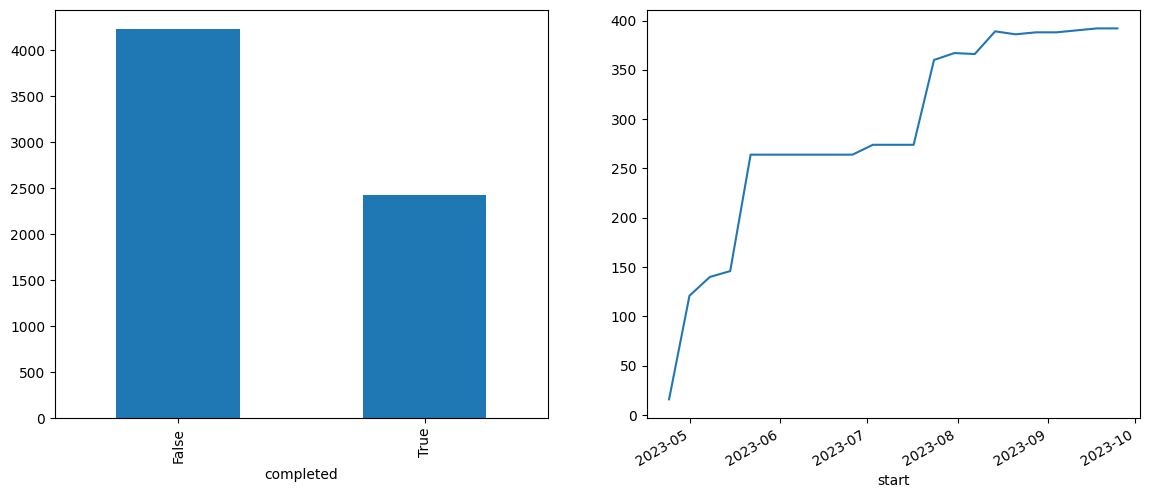

In [5]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 2, figsize=(14, 6))

df['completed'].value_counts().plot(kind='bar', ax=ax[0])
df.groupby('start').size().plot(ax=ax[1])
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder

dataset = df[['user', 'challenge', 'holiday', 'month', 'rain', 'temperature', 'completed']].copy()

user_encoder = LabelEncoder()
challenge_encoder = LabelEncoder()

dataset['user'] = user_encoder.fit_transform(dataset['user'])
dataset['challenge'] = challenge_encoder.fit_transform(dataset['challenge'])
dataset['completed'] = dataset['completed'].astype(int)

dataset

,user,challenge,holiday,month,rain,temperature,completed
0,12,61,1,4,0,1,1
1,190,242,1,4,0,1,1
2,188,242,1,4,0,1,1
3,188,61,1,4,0,1,1
4,179,242,1,4,0,1,1
...,...,...,...,...,...,...,...
6642,62,242,0,9,0,2,0
6643,62,61,0,9,0,2,0
6644,61,242,0,9,0,2,0
6645,60,242,0,9,0,2,0


In [ ]:
import seaborn as sns
import numpy as np

X = np.zeros((len(user_encoder.classes_), len(challenge_encoder.classes_)), dtype=int)

for user, challenge, completed in dataset.values:
    X[user, challenge] = 2 if completed else 1

ax = sns.heatmap(X, cmap=['white', 'red', 'green'], cbar=False)
ax.set_xlabel('Challenges')
ax.set_ylabel('Users')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

sparsity = 1 - np.count_nonzero(X) / X.size
print(f'Sparsity: {sparsity:.2%}')

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(X, test_size=0.2):
    X_train, X_test = train_test_split(X, test_size=test_size, shuffle=False)
    return X_train, X_test

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# The model

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

class TwoWayFM(nn.Module):
    def __init__(self, d, k) -> None:
        super(TwoWayFM, self).__init__()

        self.w0 = nn.Linear(1, 1, bias=True)
        self.w = nn.Embedding(d, 1)
        self.V = nn.Embedding(d, k)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        square_of_sum = torch.sum(self.V(x), dim=1) ** 2
        sum_of_square = torch.sum(self.V(x) ** 2, dim=1)
        x = self.w0(torch.sum(self.w(x), dim=1)) + 0.5 * (square_of_sum - sum_of_square).sum(dim=1, keepdim=True)
        return self.sigmoid(x)
    

class TwoWayFMDataset(Dataset):
    def __init__(self, X: pd.DataFrame) -> None:
        self.X = X.copy()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        X = torch.tensor([row['user_id'], row['item_id']], dtype=torch.long)
        y = torch.tensor([row['rating']], dtype=torch.float32)
        return X, y